# Transformers with Keras

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import warnings
warnings.simplefilter('ignore', FutureWarning)

## Data preparation

We start by define the sentences and text for translation training
Sentence Pairs: Defines a small dataset of English-Spanish sentence pairs.
Target Sequences:
Prepends "startseq" and appends "endseq" to each target sentence for the decoder to learn when to start and stop translating.

In [4]:
input_texts = [
  "Hello.", "How are you?", "I am learning machine translation", "What is your name?", "I love programming." 
]
target_texts = [
  "Hola.", "¿Cómo estás?", "Estoy aprendiendo traducción automática.", "¿Cuál es tu nombre?", "Me encanta programar."
]

target_texts = ["startseq " + x + " endseq" for x in target_texts]

Next, we convert the text from the sentences to tokens and create a vocabulary

In [5]:
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)

input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

Now, pad the corresponding sentences to ensure all sequences have the same length

In [8]:
max_input_length = max([len(seq) for seq in input_sequences])
max_output_length = max([len(seq) for seq in output_sequences])

input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

Prepare the target data for training, and convert to one-hot

In [9]:
decoder_input_data = output_sequences[:, :-1]
decoder_output_data = output_sequences[:, 1:]

decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

## Self-Attention Layer

Self-attention is a mechanism that allows a model to **focus on relevant parts of the input sequence** while processing each word. This is particularly useful in:
1) Machine Translation (e.g., aligning words correctly)
2) Text Summarization
3) Speech Recognition
4) Image Processing (Vision Transformers)
In this implementation, self-attention is used for text based sequence-to-sequence modeling.


Self-Attention works for a given an input sequence by computing a weighted representation of all words for each position. It does so using three key components:

1. Query **(Q)**, Key **(K)**, and Value **(V)** Matrices
For each word (token) in a sequence:

Query (Q): What this word is looking for.
Key (K): What this word represents.
Value (V): The actual information in the word.

2. Compute **Attention Scores**
Next, we **calculate the similarity between each query and key** using dot-product attention:
Each word in a sequence attends to every other word based on these scores.

3. Apply **Scaling & Softmax**
Since dot-product values can be large, we scale them. 
Next, Applying softmax converts scores into attention weights:


### Self-Attention class
In this implementation of self-attention layer:
1. We first initialize the weights in the **build** method, where:
    1. **self.Wq**, **self.Wk**, **self.Wv** are the trainable weight matrices.
    2. Their **shape is (feature_dim, feature_dim)**, meaning they transform input features into Q, K, and V representations.
2. Applying Attention using **call** method. The **call()** method:
   1. Computes **Q, K, V** by multiplying inputs (encoder/decoder output) with their respective weight matrices.
   2. Computes **dot-product attention scores** using K.batch_dot(q, k, axes=[2, 2]), resulting in a (batch_size, seq_len, seq_len) matrix.
   3. **Scales** the scores to avoid large values.
   4. Applies **softmax** to normalize the attention scores.
   5. **Multiplies attention weights with V** to get the final output.
3. The **compute_output_shape** method defines the shape of the output tensor after the layer processes an input.
    1. The output shape of the Self-Attention layer **remains the same** as the input shape.
    2. The attention mechanism **transforms** the input but does not change its dimensions.4
    3. If the attention layer changed the shape, you would modify compute_output_shape


In [16]:
class SelfAttention(Layer):
  def __init__(self, **kwargs):
    super(SelfAttention, self).__init__(**kwargs)

  def build(self, input_shape):
    feature_dim = input_shape[-1]

    self.Wq = self.add_weight(shape=(feature_dim, feature_dim),
                              initializer='glorot_uniform',
                              trainable=True,
                              name='Wq')
    self.Wk = self.add_weight(shape=(feature_dim, feature_dim),
                              initializer='glorot_uniform',
                              trainable=True,
                              name='Wk')
    self.Wv = self.add_weight(shape=(feature_dim, feature_dim),
                              initializer='glorot_uniform',
                              trainable=True,
                              name='Wv')
    super(SelfAttention, self).build(input_shape)

  def call(self, inputs):
    q = K.dot(inputs, self.Wq)
    k = K.dot(inputs, self.Wk)
    v = K.dot(inputs, self.Wv)

    scores = K.batch_dot(q, k, axes=[2, 2])
    scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))
    attention_weights = K.softmax(scores, axis=-1)

    output = K.batch_dot(attention_weights, v)
    return output

  def compute_output_shape(self, input_shape):
    return input_shape

## Model Architecture

The model follows an Encoder-Decoder structure:

### Encoder:
1) Takes input sentences (padded and tokenized).
2) Uses an Embedding layer (word representations) + LSTM (to process sequences).
    1. The LSTMs are used as the **help process variable-length input sentences** and generate meaningful translations.
4) Outputs context vectors (hidden & cell states).

### Attention Layer
1) Applied to both the encoder and decoder outputs.
2) Helps the decoder focus on relevant words during translation.

### Decoder
1) Receives target sequences (shifted one step ahead).
2) Uses an LSTM with encoder states as initial states.
3) Applies self-attention for better learning.
4) Uses a Dense layer (Softmax) to predict the next word.

In [19]:
from tensorflow.keras.layers import AdditiveAttention, Concatenate, Dense, Embedding, Input, LSTM
from tensorflow.keras.models import Model

# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention: decoder attends to encoder outputs
attention = AdditiveAttention()
attention_output = attention([decoder_outputs, encoder_outputs])

# Combine decoder outputs with attention context
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Final dense layer
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 5, 256)    │      4,096 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 5, 256)    │      4,352 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 5, 256),  │    525,312 │ embedding_10[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ [(None, 5, 256),  │    525,312 │ embedding_11[0][… │
│                     │ (None, 256),      │            │ lstm_10[0][1],    │
│                     │ (None, 256)]      │            │ lstm_10[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 5, 256)    │        256 │ lstm_11[0][0],    │
│ (AdditiveAttention) │                   │            │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 5, 512)    │          0 │ lstm_11[0][0],    │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5, 17)     │      8,721 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,068,049 (4.07 MB)

 Trainable params: 1,068,049 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

Uses categorical_crossentropy as the loss function since output words are one-hot encoded. Trains using Adam optimizer for 100 epochs.

In [20]:
history_glorot_adam = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 2.8343
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2800 - loss: 2.8016
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3200 - loss: 2.7670
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3200 - loss: 2.7271
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3200 - loss: 2.6780
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2800 - loss: 2.6148
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2800 - loss: 2.5313
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2400 - loss: 2.4211
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2400 - loss: 2.2849
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2400 - loss: 2.1498
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2400 - loss: 2.0795
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2400 - 

## Plotting the training loss

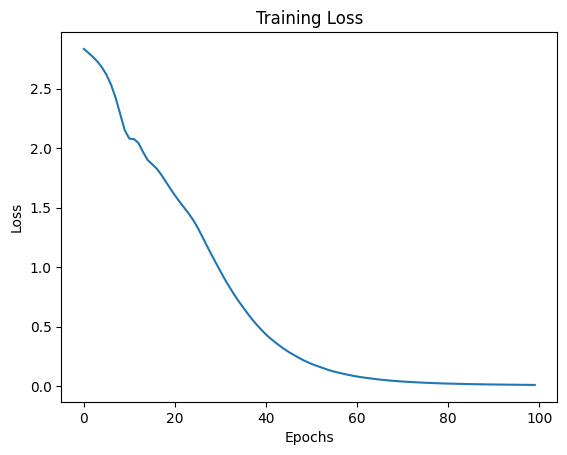

In [21]:
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Exercise 1

In this practice exercise, let's train the model using "he_uniform" initializer instead of "glorot_uniform". Then, compare the training loss between model using "glorot_uniform" vs "he_uniform" initializers by plotting them using matplotlib

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1200 - loss: 2.8350
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3600 - loss: 2.8042
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3200 - loss: 2.7726
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3200 - loss: 2.7371
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3200 - loss: 2.6946
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3200 - loss: 2.6415
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3200 - loss: 2.5727
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2800 - loss: 2.4827
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2800 - loss: 2.3672
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2800 - loss: 2.2338
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2800 - loss: 2.1225
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2800 - loss

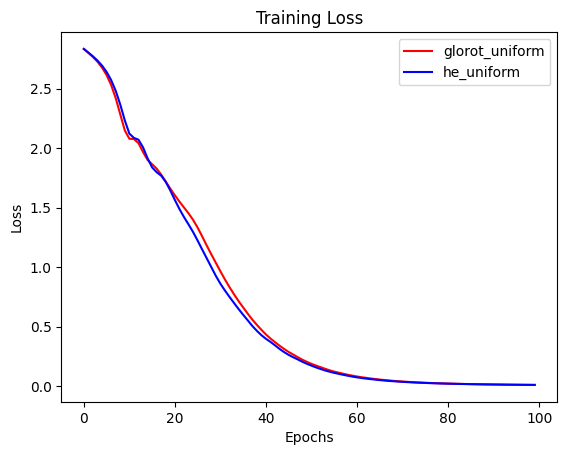

In [23]:
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        q = K.dot(inputs, self.Wq)
        k = K.dot(inputs, self.Wk)
        v = K.dot(inputs, self.Wv)

        scores = K.batch_dot(q, k, axes=[2, 2])
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))
        attention_weights = K.softmax(scores, axis=-1)

        output = K.batch_dot(attention_weights, v)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape


#Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

#Decoder
decoder_inputs = Input(shape=(max_output_length - 1,), name="decoder_inputs")
decoder_embedding = Embedding(output_vocab_size, 256, name="decoder_embedding")(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

#Attention Mechanism
attention = AdditiveAttention(name="attention_layer")
attention_output = attention([decoder_outputs, encoder_outputs])

# Concatenate context with decoder outputs
decoder_concat = Concatenate(axis=-1, name="concat_layer")([decoder_outputs, attention_output])

# Final Dense Layer
decoder_dense = Dense(output_vocab_size, activation='softmax', name="output_dense")
decoder_outputs = decoder_dense(decoder_concat)

#Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#Step 6: Train the Model
history_he = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

#Plotting training losses for glorot_uniform and he_uniform inititalizers
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="glorot_uniform", color='red')
plt.plot(history_he.history['loss'], label="he_uniform", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Exercise 2

In this practice exercise, try to use adaptive gradient optimizer instead of adam. Then, plot and compare the results between adam and adaptive gradient optimizers

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0095
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0095
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss

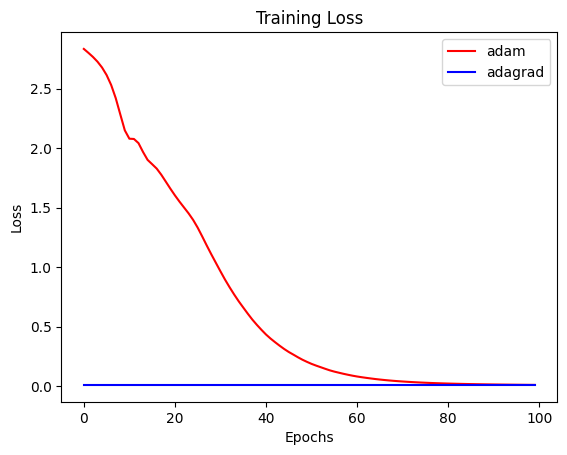

In [24]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])

history_adagrad = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

#Plotting training losses for glorot_uniform and he_uniform inititalizers
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="adam", color='red')
plt.plot(history_adagrad.history['loss'], label="adagrad", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()